In [125]:
import os
import requests
from dotenv import load_dotenv
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.backends import default_backend
import base64
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import padding, rsa
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [126]:
def parse_timestamp(ts):
    """Convert MM/DD/YYYY [HH:MM:SS] to Unix timestamp (int)."""
    if isinstance(ts, str):
        for fmt in ("%m/%d/%Y %H:%M:%S", "%m/%d/%Y %H:%M", "%m/%d/%Y"):
            try:
                return int(datetime.strptime(ts, fmt).timestamp())
            except ValueError:
                continue
        raise ValueError(f"Invalid timestamp format: {ts}")
    return ts  # assume already in correct format if not string


def format_timestamp(ts):
    """Convert Unix timestamp (int) to MM/DD/YYYY HH:MM:SS."""
    if isinstance(ts, (int, float)):
        return datetime.fromtimestamp(ts).strftime("%m/%d/%Y %H:%M:%S")
    elif isinstance(ts, str):
        try:
            ts = float(ts)
            return datetime.fromtimestamp(ts).strftime("%m/%d/%Y %H:%M:%S")
        except ValueError:
            raise ValueError(f"Invalid timestamp: {ts}")
    else:
        raise TypeError(f"Unsupported type for timestamp: {type(ts)}")


# Helper to generate headers for authentication
# Uses RSA-PSS to sign the message composed of timestamp, method, and path
def sign_request(method: str, full_path: str):
    timestamp = str(int(__import__('time').time() * 1000))
    msg = timestamp + method.upper() + full_path
    signature = base64.b64encode(
        PRIVATE_KEY.sign(
            msg.encode('utf-8'),
            padding.PSS(
                mgf=padding.MGF1(hashes.SHA256()),
                salt_length=padding.PSS.DIGEST_LENGTH
            ),
            hashes.SHA256()
        )
    ).decode('utf-8')

    headers = {
        'KALSHI-ACCESS-KEY': KEY_ID,
        'KALSHI-ACCESS-TIMESTAMP': timestamp,
        'KALSHI-ACCESS-SIGNATURE': signature,
        'accept': 'application/json',
        'content-type': 'application/json'
    }
    return headers


# Generic HTTP methods

# Generic GET request
# `endpoint` should be like '/communications/id'
# `params` is a dictionary of URL parameters
def kalshi_get(endpoint, params=None):
    full_path = "/trade-api/v2" + endpoint  # for signing
    url = BASE_URL + endpoint               # for actual request
    headers = sign_request("GET", full_path)
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    return response.json()

# Generic POST request
# `body` is a JSON-serializable dictionary
def kalshi_post(endpoint, body=None):
    full_path = "/trade-api/v2" + endpoint
    url = BASE_URL + endpoint
    headers = sign_request("POST", full_path)
    response = requests.post(url, headers=headers, json=body)
    response.raise_for_status()
    return response.json() if response.content else {}

# Generic PUT request
# Used for actions like confirming or accepting quotes
def kalshi_put(endpoint, body=None):
    full_path = "/trade-api/v2" + endpoint
    url = BASE_URL + endpoint
    headers = sign_request("PUT", full_path)
    response = requests.put(url, headers=headers, json=body)
    response.raise_for_status()
    return response.json() if response.content else {}

# Generic DELETE request
# Deletes the resource at the endpoint (quote, RFQ, etc.)
def kalshi_delete(endpoint):
    full_path = "/trade-api/v2" + endpoint
    url = BASE_URL + endpoint
    headers = sign_request("DELETE", full_path)
    response = requests.delete(url, headers=headers)
    response.raise_for_status()
    return response.status_code


# ========== Communications API Wrappers ==========

def get_api_version():
    """Returns the version of the Kalshi API currently in use."""
    return kalshi_get("/api_version")

def get_communications_id():
    """Returns the communications ID of the logged-in user."""
    return kalshi_get("/communications/id")

def get_quotes():
    """Returns all quotes visible to the user."""
    return kalshi_get("/communications/quotes")

def create_quote(rfq_id, yes_bid=None, no_bid=None, rest_remainder=False):
    """Creates a quote for an existing RFQ.
    Args:
        rfq_id (str): The RFQ ID you're responding to.
        yes_bid (int): Price in cents you're willing to pay for 'yes'.
        no_bid (int): Price in cents you're willing to pay for 'no'.
        rest_remainder (bool): Whether to leave rest of quantity available.
    """
    body = {
        "rfq_id": rfq_id,
        "yes_bid": yes_bid,
        "no_bid": no_bid,
        "rest_remainder": rest_remainder
    }
    return kalshi_post("/communications/quotes", body)

def get_quote(quote_id):
    """Retrieves a specific quote by ID."""
    return kalshi_get(f"/communications/quotes/{quote_id}")

def delete_quote(quote_id):
    """Deletes a quote so it can no longer be accepted."""
    return kalshi_delete(f"/communications/quotes/{quote_id}")

def accept_quote(quote_id, accepted_side):
    """Accepts a quote.
    Args:
        quote_id (str): The quote to accept.
        accepted_side (str): 'yes' or 'no'.
    """
    return kalshi_put(f"/communications/quotes/{quote_id}/accept", {"accepted_side": accepted_side})

def confirm_quote(quote_id):
    """Confirms a quote to trigger execution. Should be done after acceptance."""
    return kalshi_put(f"/communications/quotes/{quote_id}/confirm")

def get_rfqs():
    """Returns all RFQs visible to the user."""
    return kalshi_get("/communications/rfqs")

def create_rfq(market_ticker, contracts, rest_remainder=False):
    """Creates a new RFQ.
    Args:
        market_ticker (str): The market ticker you're requesting a quote for.
        contracts (int): The number of contracts to request.
        rest_remainder (bool): Whether the remainder can stay on the book.
    """
    body = {
        "market_ticker": market_ticker,
        "contracts": contracts,
        "rest_remainder": rest_remainder
    }
    return kalshi_post("/communications/rfqs", body)

def get_rfq(rfq_id):
    """Returns a specific RFQ by ID."""
    return kalshi_get(f"/communications/rfqs/{rfq_id}")

def delete_rfq(rfq_id):
    """Deletes an RFQ by ID."""
    return kalshi_delete(f"/communications/rfqs/{rfq_id}")

def get_events(limit=100, cursor=None, status=None, series_ticker=None, with_nested_markets=False):
    """
    Get a list of events with optional filtering.

    Parameters:
        limit (int): Max number of results (1-200)
        cursor (str): Used for pagination
        status (str): Filter events by status: unopened, open, closed, settled
        series_ticker (str): Filter events by series
        with_nested_markets (bool): Include nested market objects
    """
    params = {
        "limit": limit,
        "cursor": cursor,
        "status": status,
        "series_ticker": series_ticker,
        "with_nested_markets": with_nested_markets
    }
    return kalshi_get("/events", {k: v for k, v in params.items() if v is not None})

def get_event(event_ticker, with_nested_markets=False):
    """
    Get details for a specific event.

    Parameters:
        event_ticker (str): The event identifier
        with_nested_markets (bool): Include related markets
    """
    return kalshi_get(f"/events/{event_ticker}", {"with_nested_markets": with_nested_markets})

def get_markets(limit=100, cursor=None, event_ticker=None, series_ticker=None,
                max_close_ts=None, min_close_ts=None, status=None, tickers=None):
    """
    Get a list of markets with optional filters.

    Parameters:
        limit (int): Max number of results (1-1000)
        cursor (str): Used for pagination
        event_ticker (str): Filter markets belonging to this event
        series_ticker (str): Filter markets belonging to this series
        max_close_ts (int): Markets closing before this Unix timestamp
        min_close_ts (int): Markets closing after this Unix timestamp
        status (str): Filter by market status: unopened, open, closed, settled
        tickers (str): Comma-separated tickers to filter
    """
    max_close_ts = parse_timestamp(max_close_ts) if max_close_ts else None
    min_close_ts = parse_timestamp(min_close_ts) if min_close_ts else None
    params = {
        "limit": limit,
        "cursor": cursor,
        "event_ticker": event_ticker,
        "series_ticker": series_ticker,
        "max_close_ts": max_close_ts,
        "min_close_ts": min_close_ts,
        "status": status,
        "tickers": tickers
    }
    return kalshi_get("/markets", {k: v for k, v in params.items() if v is not None})

def get_market(ticker):
    """
    Get market details by market ticker.

    Parameters:
        ticker (str): Market ticker
    """
    return kalshi_get(f"/markets/{ticker}")

def get_market_orderbook(ticker, depth=None):
    """
    Retrieve the order book for a given market.

    Parameters:
        ticker (str): Market ticker
        depth (int): Max number of levels per side (optional)
    """
    params = {"depth": depth} if depth else None
    return kalshi_get(f"/markets/{ticker}/orderbook", params)

def get_trades(ticker=None, limit=100, cursor=None, min_ts=None, max_ts=None):
    """
    Get trade history for one or more markets.

    Parameters:
        ticker (str): Specific market ticker
        limit (int): Max number of trades to retrieve
        cursor (str): Pagination cursor
        min_ts (int): Minimum timestamp (Unix time)
        max_ts (int): Maximum timestamp (Unix time)
    """
    min_ts = parse_timestamp(min_ts) if min_ts else None
    max_ts = parse_timestamp(max_ts) if max_ts else None
    params = {
        "ticker": ticker,
        "limit": limit,
        "cursor": cursor,
        "min_ts": min_ts,
        "max_ts": max_ts
    }
    return kalshi_get("/markets/trades", {k: v for k, v in params.items() if v is not None})

def get_series_list(category=None, include_product_metadata=False):
    """
    Get a list of series optionally filtered by category.

    Parameters:
        category (str): Filter series by category
        include_product_metadata (bool): Include metadata
    """
    params = {
        "category": category,
        "include_product_metadata": include_product_metadata
    }
    return kalshi_get("/series/", {k: v for k, v in params.items() if v is not None})

def get_series(series_ticker):
    """
    Get a specific series by its ticker.

    Parameters:
        series_ticker (str): The series identifier
    """
    return kalshi_get(f"/series/{series_ticker}")

def get_market_candlesticks(series_ticker, ticker, start_ts, end_ts, period_interval):
    """
    Retrieve historical candlestick data for a market.

    Parameters:
        series_ticker (str): The series the market belongs to
        ticker (str): The market ticker
        start_ts (int): Unix timestamp for beginning of range
        end_ts (int): Unix timestamp for end of range
        period_interval (int): Time per candle in minutes (1, 60, or 1440)
    """
    start_ts = parse_timestamp(start_ts)
    end_ts = parse_timestamp(end_ts)
    params = {
        "start_ts": start_ts,
        "end_ts": end_ts,
        "period_interval": period_interval
    }
    return kalshi_get(f"/series/{series_ticker}/markets/{ticker}/candlesticks", params)

# ========== Exchange API Wrappers ==========

def get_exchange_announcements():
    """
    Retrieve all exchange-wide announcements.

    Returns:
        List of announcement objects with timestamps and message details.
    """
    return kalshi_get("/exchange/announcements")

def get_exchange_schedule():
    """
    Retrieve the current exchange operating schedule.

    Returns:
        Schedule object with daily hours and trading availability.
    """
    return kalshi_get("/exchange/schedule")

def get_exchange_status():
    """
    Retrieve the current operational status of the exchange.

    Returns:
        Status object including live or maintenance info.
    """
    return kalshi_get("/exchange/status")

def get_user_data_timestamp():
    """
    Retrieve the timestamp of the last backend data update for user-specific views.
    Useful for syncing between API fetches and websocket updates.

    Returns:
        Object with keys like "orders_ts", "positions_ts", etc.
    """
    return kalshi_get("/exchange/user_data_timestamp")

# ========== Milestones API Wrappers ==========

def get_milestones(limit, minimum_start_date=None, category=None, type=None, related_event_ticker=None, cursor=None):
    """
    Retrieve a list of milestones, with optional filters.

    Parameters:
        limit (int): Number of results (1 to 500) — required.
        minimum_start_date (str): ISO format datetime to filter by start date.
        category (str): Filter milestones by category.
        type (str): Filter milestones by type.
        related_event_ticker (str): Filter by related event.
        cursor (str): Pagination cursor.

    Returns:
        List of milestone metadata.
    """
    params = {
        "limit": limit,
        "minimum_start_date": minimum_start_date,
        "category": category,
        "type": type,
        "related_event_ticker": related_event_ticker,
        "cursor": cursor
    }
    return kalshi_get("/milestones/", {k: v for k, v in params.items() if v is not None})

def get_milestone(milestone_id):
    """
    Retrieve details for a specific milestone by its ID.

    Parameters:
        milestone_id (str): Unique milestone identifier.

    Returns:
        Milestone details.
    """
    return kalshi_get(f"/milestones/{milestone_id}")

# ========== Multivariate Collections API Wrappers ==========

def get_event_collections(status=None, associated_event_ticker=None, series_ticker=None, limit=100, cursor=None):
    """
    Retrieve multivariate event collections.

    Parameters:
        status (str): Filter collections by status (unopened, open, closed).
        associated_event_ticker (str): Filter by related event ticker.
        series_ticker (str): Filter by series ticker.
        limit (int): Number of results (1 to 200).
        cursor (str): Pagination cursor.

    Returns:
        List of event collection metadata.
    """
    params = {
        "status": status,
        "associated_event_ticker": associated_event_ticker,
        "series_ticker": series_ticker,
        "limit": limit,
        "cursor": cursor
    }
    return kalshi_get("/multivariate_event_collections/", {k: v for k, v in params.items() if v is not None})

def get_event_collection(collection_ticker):
    """
    Retrieve a specific multivariate event collection.

    Parameters:
        collection_ticker (str): Collection identifier.

    Returns:
        Metadata and structure of the event collection.
    """
    return kalshi_get(f"/multivariate_event_collections/{collection_ticker}")

# ========== Portfolio API Wrappers ==========

def get_balance():
    """Retrieve the current account balance."""
    return kalshi_get("/portfolio/balance")

def get_fills(ticker=None, order_id=None, min_ts=None, max_ts=None, limit=100, cursor=None):
    """Retrieve executed trade fills."""
    min_ts = parse_timestamp(min_ts) if min_ts else None
    max_ts = parse_timestamp(max_ts) if max_ts else None
    params = {
        "ticker": ticker,
        "order_id": order_id,
        "min_ts": min_ts,
        "max_ts": max_ts,
        "limit": limit,
        "cursor": cursor
    }
    return kalshi_get("/portfolio/fills", {k: v for k, v in params.items() if v is not None})

def get_orders(ticker=None, event_ticker=None, min_ts=None, max_ts=None, status=None, limit=100, cursor=None):
    """Retrieve all orders."""
    min_ts = parse_timestamp(min_ts) if min_ts else None
    max_ts = parse_timestamp(max_ts) if max_ts else None
    params = {
        "ticker": ticker,
        "event_ticker": event_ticker,
        "min_ts": min_ts,
        "max_ts": max_ts,
        "status": status,
        "limit": limit,
        "cursor": cursor
    }
    return kalshi_get("/portfolio/orders", {k: v for k, v in params.items() if v is not None})

def get_order(order_id):
    """Retrieve a specific order by ID."""
    return kalshi_get(f"/portfolio/orders/{order_id}")

def create_order(order_data):
    """Submit a new order.

    Args:
        order_data (dict): Must include fields like ticker, side, type, count, and price (yes_price or no_price).

    Returns:
        Confirmation with order ID.
    """
    return kalshi_post("/portfolio/orders", order_data)

def batch_create_orders(order_list):
    """Submit multiple orders in a single request (advanced users only)."""
    return kalshi_post("/portfolio/orders/batched", {"orders": order_list})

def cancel_order(order_id):
    """Cancel a specific order by ID."""
    return kalshi_delete(f"/portfolio/orders/{order_id}")

def batch_cancel_orders(order_ids):
    """Cancel multiple orders by ID (advanced users only)."""
    return kalshi_delete("/portfolio/orders/batched", {"ids": order_ids})

def decrease_order(order_id, reduce_by=None, reduce_to=None):
    """Decrease the number of contracts in an existing order."""
    body = {"reduce_by": reduce_by, "reduce_to": reduce_to}
    return kalshi_post(f"/portfolio/orders/{order_id}/decrease", {k: v for k, v in body.items() if v is not None})

def get_positions(ticker=None, event_ticker=None, count_filter=None, settlement_status="unsettled", limit=100, cursor=None):
    """Get all market positions."""
    params = {
        "ticker": ticker,
        "event_ticker": event_ticker,
        "count_filter": count_filter,
        "settlement_status": settlement_status,
        "limit": limit,
        "cursor": cursor
    }
    return kalshi_get("/portfolio/positions", {k: v for k, v in params.items() if v is not None})

def get_portfolio_settlements(limit=100, min_ts=None, max_ts=None, cursor=None):
    """Retrieve historical portfolio settlements."""
    min_ts = parse_timestamp(min_ts) if min_ts else None
    max_ts = parse_timestamp(max_ts) if max_ts else None
    params = {
        "limit": limit,
        "min_ts": min_ts,
        "max_ts": max_ts,
        "cursor": cursor
    }
    return kalshi_get("/portfolio/settlements", {k: v for k, v in params.items() if v is not None})

def get_total_resting_order_value():
    """Retrieve the total value of resting orders (FCM members only)."""
    return kalshi_get("/portfolio/summary/total_resting_order_value")

# ========== Structured Targets API Wrappers ==========

def get_structured_target(structured_target_id):
    """Retrieve a structured target by ID.

    Args:
        structured_target_id (str): The ID of the structured target.

    Returns:
        JSON response containing structured target metadata.
    """
    return kalshi_get(f"/structured_targets/{structured_target_id}")

In [127]:
def candlesticks_to_df(candlestick_response):
    """Convert candlestick API response to DataFrame with readable timestamps."""
    rows = []
    for candle in candlestick_response["candlesticks"]:
        row = {
            "end_period": format_timestamp(candle["end_period_ts"]),
            "volume": candle["volume"],
            "open_interest": candle["open_interest"],
        }

        # Flatten nested dictionaries
        for section in ["yes_bid", "yes_ask", "price"]:
            for k, v in candle.get(section, {}).items():
                row[f"{section}_{k}"] = v

        rows.append(row)

    return pd.DataFrame(rows)

import pandas as pd
from datetime import datetime
import mplfinance as mpf

def get_all_markets(status=None, batch_size=1000):
    all_markets = []
    cursor = None
    while True:
        response = get_markets(limit=batch_size, status=status, cursor=cursor)
        all_markets.extend(response["markets"])
        
        cursor = response.get("cursor")  # <==== this is the real fix
        if not cursor:
            break

    return all_markets

def build_candlestick(candlestick_data):
    """Convert Kalshi candlestick API data to DataFrame for plotting."""
    records = []
    for entry in candlestick_data["candlesticks"]:
        row = {
            "Date": datetime.fromtimestamp(entry["end_period_ts"]),
            "Open": entry["price"]["open"] or entry["yes_bid"].get("open"),
            "High": entry["price"]["high"] or entry["yes_bid"].get("high"),
            "Low": entry["price"]["low"] or entry["yes_bid"].get("low"),
            "Close": entry["price"]["close"] or entry["yes_bid"].get("close"),
            "Volume": entry["volume"]
        }
        records.append(row)
    df = pd.DataFrame(records)
    df.set_index("Date", inplace=True)
    return df

In [128]:
"""
Kalshi API Utility Functions
=============================
This module provides signed and authenticated access to the Kalshi Trading API, including tools for working with quotes, RFQs, and account information.
It supports all major HTTP methods (GET, POST, PUT, DELETE) with RSA-based authentication using your Kalshi credentials.

Environment variables required (set in `.env`):
- PROD_KEYID / DEMO_KEYID: Your Kalshi key ID
- PROD_KEYFILE / DEMO_KEYFILE: Path to your RSA private key file
- ENV: Either "PROD" or "DEMO" to toggle environments
"""

# Load environment variables from .env
load_dotenv()

ENVIRONMENT = os.getenv("ENV", "DEMO")
KEY_ID = os.getenv(f"{ENVIRONMENT}_KEYID")
KEY_FILE = os.getenv(f"{ENVIRONMENT}_KEYFILE")
BASE_URL = "https://api.elections.kalshi.com/trade-api/v2" # Production URL
# BASE_URL = "https://demo-api.kalshi.co/trade-api/v2" # Demo URL

# Load private key
with open(KEY_FILE, "rb") as key_file:
    PRIVATE_KEY = serialization.load_pem_private_key(
        key_file.read(),
        password=None,
        backend=default_backend()
    )

In [219]:
from datetime import datetime, timedelta

def get_full_market(series_ticker, ticker, period_interval, start_ts=None, end_ts=None):
    """
    Fetch full historical candlesticks for a market by looping in 5000-period chunks.

    Args:
        series_ticker (str)
        ticker (str)
        start_ts (str or datetime): MM/DD/YYYY or datetime object
        end_ts (str or datetime): MM/DD/YYYY or datetime object
        period_interval (int): Minutes (1, 60, 1440)

    Returns:
        List of all candlestick entries
    """
    if isinstance(period_interval, str):
        period_interval = {"m": 1, "h": 60, "d": 1440}[period_interval.lower()]

    if start_ts is None or end_ts is None:
        market_meta = get_market(ticker)
        if start_ts is None:
            start_ts = datetime.fromisoformat(market_meta['market']['open_time'].replace("Z", "")).replace(tzinfo=None)
        if end_ts is None:
            end_ts = datetime.fromisoformat(market_meta['market']['close_time'].replace("Z", "")).replace(tzinfo=None)

    if isinstance(start_ts, str):
        start_ts = datetime.strptime(start_ts, "%m/%d/%Y")
    if isinstance(end_ts, str):
        end_ts = datetime.strptime(end_ts, "%m/%d/%Y")

    all_candles = []
    chunk = timedelta(minutes=period_interval * 5000)
    cur_start = start_ts

    while cur_start < end_ts:
        cur_end = min(cur_start + chunk, end_ts)
        response = get_market_candlesticks(
            series_ticker=series_ticker,
            ticker=ticker,
            start_ts=cur_start.strftime("%m/%d/%Y %H:%M:%S"),
            end_ts=cur_end.strftime("%m/%d/%Y %H:%M:%S"),
            period_interval=period_interval
        )
        all_candles.extend(response.get("candlesticks", []))
        cur_start = cur_end

    return {
        "ticker": ticker,
        "candlesticks": all_candles
    }


import pandas as pd
from datetime import datetime

def format_event(event_ticker):
    data = get_event(event_ticker)
    event = data["event"]
    markets = data["markets"]

    # Create a summary DataFrame of markets
    market_df = pd.DataFrame([{
        "market_ticker": m["ticker"],
        "yes_sub_title": m.get("yes_sub_title"),
        "range": m.get("subtitle") or f"{m.get('floor_strike', '')} – {m.get('cap_strike', '')}",
        "strike_type": m.get("strike_type"),
        "last_price": m.get("last_price"),
        "yes_bid": m.get("yes_bid"),
        "yes_ask": m.get("yes_ask"),
        "no_bid": m.get("no_bid"),
        "no_ask": m.get("no_ask"),
        "volume": m.get("volume"),
        "open_time": m.get("open_time"),
        "close_time": m.get("close_time"),
        "status": m.get("status"),
        "rules_primary": m.get("rules_primary"),
    } for m in markets])

    # Convert relevant timestamps
    if "strike_date" in event:
        event["strike_date"] = datetime.fromisoformat(event["strike_date"].replace("Z", "+00:00"))

    event_info = {
        "event_ticker": event["event_ticker"],
        "series_ticker": event["series_ticker"],
        "title": event["title"],
        "subtitle": event.get("sub_title", ""),
        "strike_date": event.get("strike_date"),
        "category": event.get("category", ""),
        "market_count": len(market_df),
    }

    return {
        "event_info": event_info,
        "markets": market_df
    }


In [ ]:
import pandas as pd
markets_data = get_all_markets()
markets_df = pd.json_normalize(markets_data)

# # Generate timestamped filename
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# filename = f"AllMarkets_{timestamp}.csv"

# # Create directory if it doesn't exist
# output_dir = "pulled_data"
# os.makedirs(output_dir, exist_ok=True)

# # Save the DataFrame
# filepath = os.path.join(output_dir, filename)
# markets_df.to_csv(filepath, index=False)

# print(f"Saved to: {filepath}")

markets_df

In [221]:
markets_df =  pd.read_csv(r"pulled_data\AllMarkets_20250425_090031.csv")

C:\Users\nicco\AppData\Local\Temp\ipykernel_46572\1126143296.py:1: DtypeWarning: Columns (29,31,34,37,42,43,44,45,46,47,48,49,50,51,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,85,86,87,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,112,113,114,115,116,117,118,119,120,121,122,123,124,125) have mixed types. Specify dtype option on import or set low_memory=False.
  markets_df =  pd.read_csv(r"pulled_data\AllMarkets_20250425_090031.csv")


In [210]:
markets_df[(markets_df['status'] == "finalized")] 

,ticker,event_ticker,market_type,title,subtitle,yes_sub_title,no_sub_title,open_time,close_time,expected_expiration_time,...,custom_strike.Joins/Leaves,custom_strike.President,custom_strike.Epidemic Level,custom_strike.Joines/Leaves,custom_strike.Above,custom_strike.Inflation,custom_strike.Unemployment,custom_strike.Date,custom_strike.Expo_Date,custom_strike.Interest Rate
10383,KXMLBGAME-25APR24TBAZ-TB,KXMLBGAME-25APR24TBAZ,binary,Tampa Bay vs Arizona Winner?,NaN,Tampa Bay,Tampa Bay,2025-04-24 13:30:00+00:00,2025-04-25 04:58:27.041276+00:00,2025-04-25T04:40:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10384,KXMLBGAME-25APR24TBAZ-AZ,KXMLBGAME-25APR24TBAZ,binary,Tampa Bay vs Arizona Winner?,NaN,Arizona,Arizona,2025-04-24 13:30:00+00:00,2025-04-25 04:58:27.041276+00:00,2025-04-25T04:40:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10385,KXMLBGAME-25APR24CWSMIN-MIN,KXMLBGAME-25APR24CWSMIN,binary,Chicago WS vs Minnesota Winner?,NaN,Minnesota,Minnesota,2025-04-24 13:30:00+00:00,2025-04-24 21:06:09.178173+00:00,2025-04-24T20:10:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10386,KXMLBGAME-25APR24CWSMIN-CWS,KXMLBGAME-25APR24CWSMIN,binary,Chicago WS vs Minnesota Winner?,NaN,Chicago WS,Chicago WS,2025-04-24 13:30:00+00:00,2025-04-24 21:06:09.178173+00:00,2025-04-24T20:10:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10387,KXMLBGAME-25APR24COLKCG1-COL,KXMLBGAME-25APR24COLKCG1,binary,Colorado vs Kansas City (Game 1) Winner?,NaN,Colorado,Colorado,2025-04-24 13:30:00+00:00,2025-04-24 20:50:18.851408+00:00,2025-04-24T21:10:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385130,TEMP-21-T2.124,TEMP-21,binary,Will 2021 be the **hottest year on record**?,NaN,Above 2.124° C,2.124° C or below,2021-07-02 14:00:00+00:00,2022-01-10 00:00:00+00:00,2021-07-02T14:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1385131,HOME-21JUN-T750,HOME-21JUN,binary,"Will new U.S. home sales be above 750,000?",>750K,"Above 750,000","750,000 or below",2021-06-30 14:00:00+00:00,2021-07-25 23:00:00+00:00,2021-06-30T14:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1385132,GDP-21JUN30-T6.0,GDP-21JUN30,binary,Will real GDP increase by more than 6%?,>6%,Above 6%,6% or below,2021-06-30 14:00:00+00:00,2021-07-28 23:00:00+00:00,2021-06-30T14:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1385133,TRDDEFCN-21MAY-T30,TRDDEFCN-21MAY,binary,Will the US trade deficit in goods with China ...,>$30bn,Above $30 billion,$30 billion or below,2021-06-30 14:00:00+00:00,2021-07-01 23:00:00+00:00,2021-06-30T14:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [211]:
# markets_df['open_time'] = pd.to_datetime(markets_df['open_time'], format='mixed')
# markets_df['close_time'] = pd.to_datetime(markets_df['close_time'], format='mixed')
# sorted_df = (
#     markets_df[(markets_df['title'].str.contains("S&P 500")) & (markets_df['status'] == "finalized")]
#     .assign(duration=lambda df: df['close_time'] - df['open_time'])
#     .sort_values(by='duration', ascending=False)
# )
# sorted_df

In [426]:
out = format_event("PRES-2024")
out["markets"]#, out["event_info"]

,market_ticker,yes_sub_title,range,strike_type,last_price,yes_bid,yes_ask,no_bid,no_ask,volume,open_time,close_time,status,rules_primary
0,PRES-2024-KH,Kamala Harris,:: or another Democrat,custom,1,0,1,99,100,273312857,2024-10-04T12:15:00Z,2025-01-20T17:03:48.078202Z,finalized,If Kamala Harris or another representative of ...
1,PRES-2024-DJT,Donald Trump,:: or another Republican,None,99,99,100,0,1,262334207,2024-10-04T12:15:00Z,2025-01-20T17:03:48.078202Z,finalized,If Donald Trump or another representative of t...
2,PRES-2024-RFK,Robert F. Kennedy Jr.,:: or another We the People nominee,custom,1,0,1,99,100,224361,2024-10-04T12:15:00Z,2025-01-20T17:03:48.078202Z,finalized,If Robert F. Kennedy Jr. or another representa...
3,PRES-2024-JS,Jill Stein,:: or another Green Party nominee,custom,1,0,1,99,100,40394,2024-10-04T12:15:00Z,2025-01-20T17:03:48.078202Z,finalized,If Jill Stein or another representative of the...
4,PRES-2024-CO,Chase Oliver,:: or another Libertarian,custom,1,0,1,99,100,20834,2024-10-04T12:15:00Z,2025-01-20T17:03:48.078202Z,finalized,If Chase Oliver or another representative of t...
5,PRES-2024-CW,Cornel West,:: or another Justice for All nominee,custom,1,0,1,99,100,16290,2024-10-04T12:15:00Z,2025-01-20T17:03:48.078202Z,finalized,If Cornel West or another representative of th...


In [ ]:
import numpy as np

def parse_range_string(s):
    s = s.replace(',', '')  # remove commas
    if "or lower" in s or "or below" in s:
        max_val = float(s.split(" ")[0])
        return (0.0, max_val)
    elif "or higher" in s or "or above" in s:
        min_val = float(s.split(" ")[0])
        return (min_val, np.inf)
    elif "to" in s:
        parts = s.split(" to ")
        return (float(parts[0]), float(parts[1]))
    else:
        raise ValueError(f"Unrecognized format: {s}")

results = {}

for market in out["markets"]["market_ticker"].values:
    cs_df = candlesticks_to_df(get_full_market(series_ticker="KXLLM1", ticker=market, period_interval='h', end_ts='11/10/2024'))[['end_period', 'yes_ask_close', 'yes_bid_close', 'volume']]
    
    cs_df['end_period'] = pd.to_datetime(cs_df['end_period'])
    cs_df['date'] = cs_df['end_period']
    cs_df['midval'] = (cs_df['yes_ask_close'] + cs_df['yes_bid_close']) / 2
    cs_df['ask'] = cs_df['yes_ask_close']
    cs_df['bid'] = cs_df['yes_bid_close']
    cs_df = cs_df.drop(columns=['yes_ask_close', 'yes_bid_close', 'end_period'])
    cs_df.set_index('date', inplace=True)
    title = out["markets"].loc[out["markets"]["market_ticker"] == market, "yes_sub_title"].values[0]
    # range = parse_range_string(range)

    results[title] = cs_df

# data = pd.DataFrame(results)

In [502]:
# Step 1: Compute the global index (union of all datetime indices)
all_indices = sorted(set().union(*[df.index for df in results.values()]))
global_index = pd.DatetimeIndex(all_indices)

# Step 2: Build the full DataFrame with aligned index
results_df = pd.DataFrame(index=global_index)

# Step 3: Merge all time series, aligned on the global index
for title, df in results.items():
    df = df.groupby(df.index).mean()  # or .sum(), or use .duplicated() line

    renamed_df = df.rename(columns={
        'midval': f'{title}_midval',
        'ask': f'{title}_ask',
        'bid': f'{title}_bid',
        'volume': f'{title}_volume'
    })

    renamed_df = renamed_df.reindex(global_index)
    results_df = pd.concat([results_df, renamed_df], axis=1)

# results_df.ffill(inplace=True)
for col in results_df.columns:
    if '_midval' in col:
        vol_col = col.replace('_midval', '_volume')
        filled_series = results_df[col].copy()
        volume_series = results_df[vol_col]

        for i in range(1, len(filled_series)):
            if pd.isna(filled_series.iloc[i]) and pd.notna(volume_series.iloc[i-1]) and volume_series.iloc[i-1] > 200:
                filled_series.iloc[i] = filled_series.iloc[i - 1]

        results_df[col] = filled_series

# Step 4: Final computed columns
results_df['Vol'] = results_df[[col for col in results_df.columns if '_volume' in col]].sum(axis=1)
results_df['Tot'] = results_df[[col for col in results_df.columns if '_midval' in col]].sum(axis=1)

results_df.index.name = 'date'
results_df


,Kamala Harris_volume,Kamala Harris_midval,Kamala Harris_ask,Kamala Harris_bid,Donald Trump_volume,Donald Trump_midval,Donald Trump_ask,Donald Trump_bid,Robert F. Kennedy Jr._volume,Robert F. Kennedy Jr._midval,...,Chase Oliver_volume,Chase Oliver_midval,Chase Oliver_ask,Chase Oliver_bid,Cornel West_volume,Cornel West_midval,Cornel West_ask,Cornel West_bid,Vol,Tot
date,,,,,,,,,,,,,,,,,,,,,
2024-10-04 13:00:00,24083.0,50.5,51.0,50.0,39835.0,49.5,50.0,49.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,0.5,1.0,0.0,63919.0,100.5
2024-10-04 14:00:00,4330.0,50.5,51.0,50.0,3390.0,49.5,50.0,49.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7720.0,100.0
2024-10-04 15:00:00,6199.0,50.5,51.0,50.0,3382.0,49.5,50.0,49.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9581.0,100.0
2024-10-04 16:00:00,2814.0,50.5,51.0,50.0,3804.0,49.5,50.0,49.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6618.0,100.0
2024-10-04 17:00:00,8601.0,50.5,51.0,50.0,21784.0,49.5,50.0,49.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30385.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-09 20:00:00,21514.0,1.5,2.0,1.0,54705.0,97.5,98.0,97.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76219.0,99.0
2024-11-09 21:00:00,56499.0,1.5,2.0,1.0,77001.0,97.5,98.0,97.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133500.0,99.0
2024-11-09 22:00:00,94528.0,1.5,2.0,1.0,41228.0,97.5,98.0,97.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135756.0,99.0


In [503]:
# results_df = pd.DataFrame()

# for title, df in results.items():
#     renamed_df = df.rename(columns={
#         'midval': f'{title}_midval',
#         'ask': f'{title}_ask',
#         'bid': f'{title}_bid',
#         'volume': f'{title}_volume'
#     })
#     results_df = pd.concat([results_df, renamed_df], axis=1)

# # results_df.ffill(inplace=True)

# results_df['Vol'] = results_df[[col for col in results_df.columns if '_volume' in col]].sum(axis=1)
# results_df['Tot'] = results_df[[col for col in results_df.columns if '_midval' in col]].sum(axis=1)

# results_df.index = pd.to_datetime(results_df.index)
# results_df.index.name = 'date'
# results_df

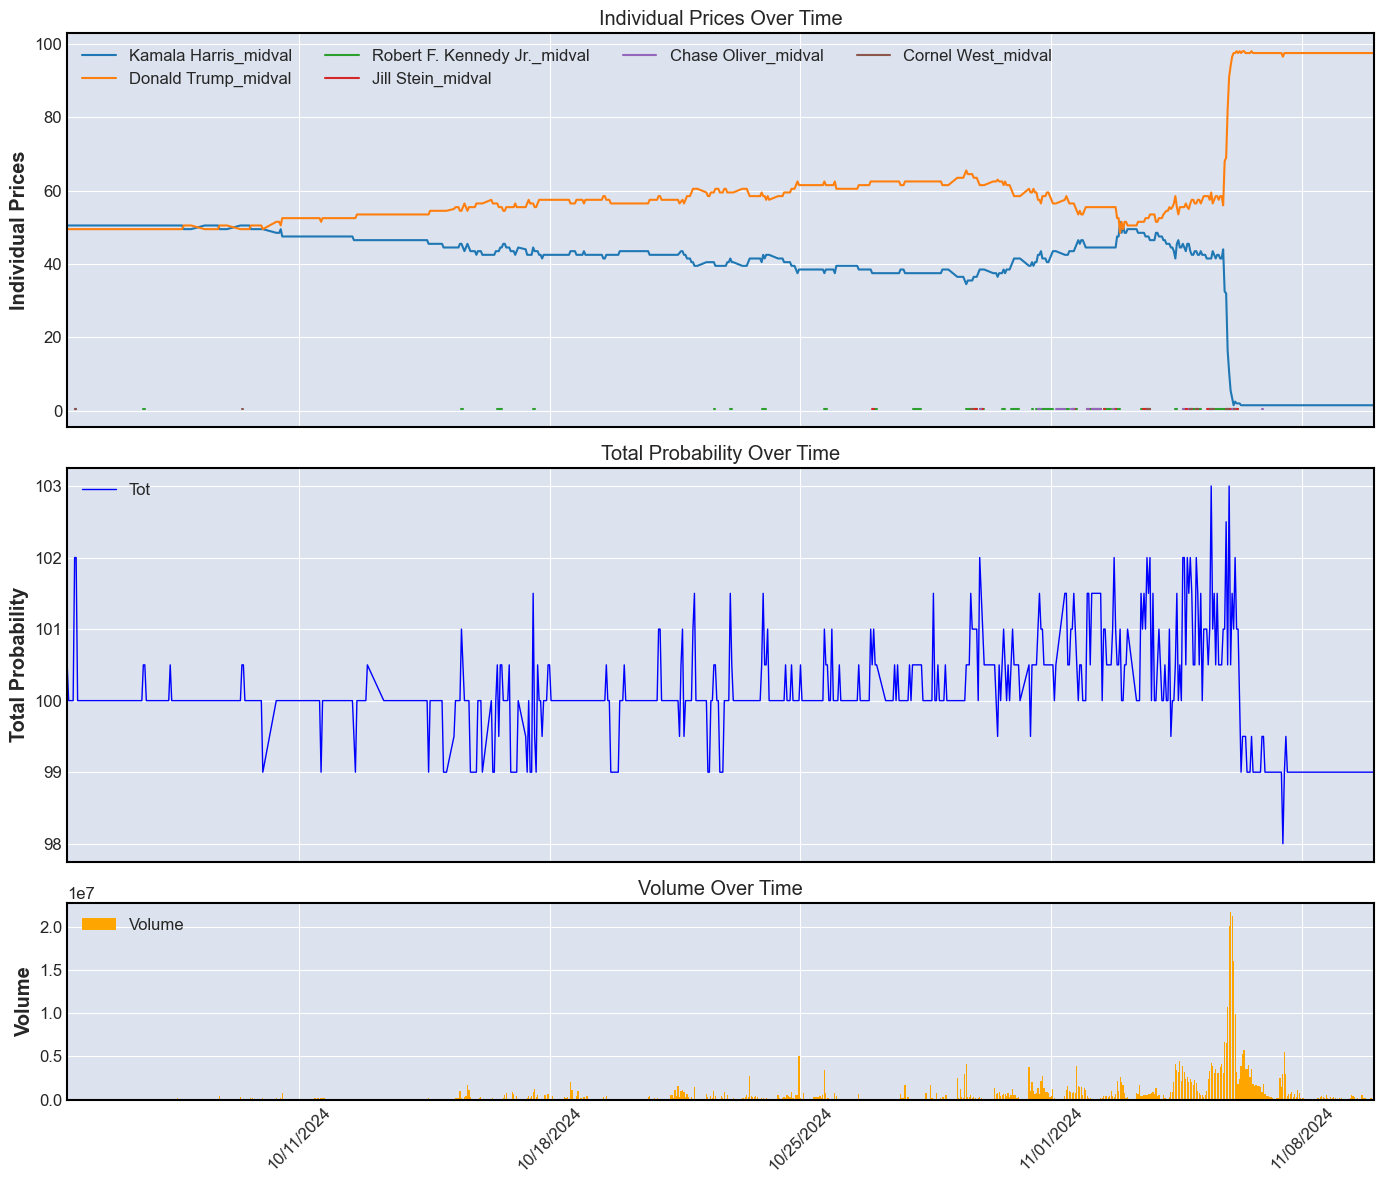

In [504]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

plot_df = results_df.reset_index()

# Identify price columns (all columns except 'date', 'Tot', and 'Vol')
price_columns = [col for col in plot_df.columns if "_midval" in col]

# Create a figure with 3 subplots, making the top two price plots the same size
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(14, 12), 
                                    gridspec_kw={'height_ratios': [2, 2, 1]}, 
                                    sharex=True)

# Plot 1: Individual Prices
for col in price_columns:
    ax1.plot(plot_df['date'], plot_df[col], linewidth=1.5, label=col)
ax1.set_ylabel('Individual Prices')
ax1.set_title('Individual Prices Over Time')
ax1.legend(loc='upper left', ncol=min(4, len(price_columns)))
ax1.grid(True)
plt.setp(ax1.get_xticklabels(), visible=False)

# Plot 2: Total Probability
ax2.plot(plot_df['date'], plot_df['Tot'], color='blue', linewidth=1, label='Tot')
ax2.set_ylabel('Total Probability')
ax2.set_title('Total Probability Over Time')
ax2.legend(loc='upper left')
ax2.grid(True)
plt.setp(ax2.get_xticklabels(), visible=False)

# Calculate appropriate width for bars
if plot_df.shape[0] > 1:
    time_diff = (plot_df['date'].iloc[1] - plot_df['date'].iloc[0]).total_seconds()
    width_in_days = (time_diff / (24 * 60 * 60)) * 0.8
else:
    width_in_days = 0.01

# Plot 3: Volume
ax3.bar(plot_df['date'], plot_df['Vol'], color='orange', width=width_in_days, label='Volume')
ax3.set_ylabel('Volume')
ax3.set_title('Volume Over Time')
ax3.legend(loc='upper left')
ax3.grid(True)

# Format only the bottom x-axis with more compact labels
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# Adjust the x-axis limits to match your data range
date_min = plot_df['date'].min()
date_max = plot_df['date'].max()
ax3.set_xlim(date_min, date_max)

plt.tight_layout()
plt.show()

In [305]:
results_df

,Arizona,Tampa Bay,Vol,Tot
date,,,,
2025-04-24 13:58:00,55.5,44.5,1.0,100.0
2025-04-24 13:59:00,55.5,44.5,21.0,100.0
2025-04-24 14:00:00,55.5,44.5,0.0,100.0
2025-04-24 14:05:00,55.5,44.5,21.0,100.0
2025-04-24 14:24:00,55.5,44.5,3.0,100.0
...,...,...,...,...
2025-04-25 00:51:00,0.5,99.5,32.0,100.0
2025-04-25 00:52:00,0.5,99.5,97.0,100.0
2025-04-25 00:53:00,0.5,99.5,447.0,100.0


In [159]:
candlesticks_to_df(get_full_market(series_ticker="KXINXY", ticker="INXY-23DEC29-B4600", period_interval='h'))

,end_period,volume,open_interest,yes_bid_open,yes_bid_low,yes_bid_high,yes_bid_close,yes_ask_open,yes_ask_low,yes_ask_high,yes_ask_close,price_open,price_low,price_high,price_close,price_mean,price_previous
0,12/13/2022 17:00:00,0,0,0,0,8,8,14,12,14,12,NaN,NaN,NaN,NaN,NaN,NaN
1,12/13/2022 20:00:00,0,0,8,8,8,8,12,12,13,12,NaN,NaN,NaN,NaN,NaN,NaN
2,12/14/2022 04:00:00,0,0,8,8,8,8,12,12,13,13,NaN,NaN,NaN,NaN,NaN,NaN
3,12/14/2022 09:00:00,0,0,8,8,8,8,13,12,13,12,NaN,NaN,NaN,NaN,NaN,NaN
4,12/14/2022 11:00:00,0,0,8,7,8,8,12,12,12,12,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006,12/29/2023 11:00:00,0,110510,0,0,0,0,3,1,3,1,NaN,NaN,NaN,NaN,NaN,1.0
2007,12/29/2023 12:00:00,3300,113810,0,0,0,0,1,1,2,2,1.0,1.0,1.0,1.0,1.0,1.0
2008,12/29/2023 13:00:00,300,114010,0,0,0,0,2,1,2,2,1.0,1.0,2.0,2.0,1.0,1.0
2009,12/29/2023 14:00:00,0,114010,0,0,0,0,2,1,2,1,NaN,NaN,NaN,NaN,NaN,2.0


In [ ]:
from IPython.display import display

for market in out["markets"]['market_ticker']:
    market_data = get_market(market)
    display(market)
    display(market_data)

In [ ]:
markets_df[markets_df['ticker'].str.contains('PRES-2024')]

In [ ]:
pres_djt_data = get_full_market(
    series_ticker="PRES",
    ticker="PRES-2024-DJT",
    # start_ts="04/01/2024",
    end_ts="11/10/2024",
    period_interval='d'
)

pres_kh_data = get_full_market(
    series_ticker="PRES",
    ticker="PRES-2024-KH",
    # start_ts="04/01/2024",
    end_ts="11/10/2024",
    period_interval='h'
)

In [ ]:
djt_df = candlesticks_to_df(pres_djt_data)
kh_df = candlesticks_to_df(pres_kh_data)

djt_candlestick_df = build_candlestick(pres_djt_data)
kh_candlestick_df = build_candlestick(pres_kh_data)

import mplfinance as mpf

fig, axes = mpf.plot(
    kh_candlestick_df,
    volume=True,
    figratio=(20, 10),
    figscale=1.8,
    show_nontrading=False,
    mav=3*24,
    returnfig=True,
    type='line',
)

# Set y-axis limits for the price chart (first axes object)
# axes[0].set_ylim(0, 60)  # customize as needed

# Add a horizontal line at y=50
axes[0].axhline(y=50, color='red', linestyle='--', linewidth=1)
axes[0].axvline(x=datetime.strptime('Feb 3 1970 00:00', '%b %d %Y %H:%M'), color='blue', linestyle='--', linewidth=1) # Don't know why date is fucked up here